<a href="https://colab.research.google.com/github/EliseLodewyckx/AnimalShelter/blob/master/Animal_Shelter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Animal Shelter
This is a project we worked on lin May 2018 during exploration days. We used the Animal Shelter data from [Kaggle](https://www.kaggle.com/c/shelter-animal-outcomes/data). We wanted to see if we could predict whether a dog or cat would die in the animal shelter or if it gets adopted.

First thing we had to do was clean up the data. To minimize the time we should spent on this, we only started with the easy to use features from the dataset. We started with Animal Type, Gender, whether the animal was neutered or spayed and if it was a mixed breed. Only Animal Type we could use as it was. 

For this demo, we use a semi-prepped dataset where we splitted the gender from the neutered or spayed mark and for mix we looked for the samples where the word 'mix' was present in the breed. 
If the gender was unknown, we assumed that the mark was intact.

The outcome type is the variable that we were trying to predict. 

In [0]:
import pandas as pd
import io

In [3]:
url = 'https://raw.githubusercontent.com/EliseLodewyckx/AnimalShelter/master/data/train_basic_features.csv'

dataset = pd.read_csv(url, sep=';', engine='python', header=0)

print(dataset.head())

       OutcomeType AnimalType SexuponOutcome  Neutered  Mix
0  Return_to_owner        Dog           Male         1    1
1       Euthanasia        Cat         Female         1    1
2         Adoption        Dog           Male         1    1
3         Transfer        Cat           Male         0    1
4         Transfer        Dog           Male         1    0


We started out with all outcome types. Before asking ourselves (and the customer) the question if this was usefull information. It was not. The customer was not interested in exactly what would happen to the animal, he just wanted to know if it was likely that an animal would die in the shelter, so that he could maybe spent some more on marketing for that animal when trying to prevent that. So 'Ailve' and 'Dead' would be more interesting categories to predict. So we mapped the categories 'Died' and 'Euthanasia' to 'Dead' and the others to 'Alive'

In [4]:
dataset['OutcomeType'] = dataset['OutcomeType'].apply(lambda x : 'Dead' if x == 'Died' or x == 'Euthanasia' or x =='Dead' else 'Alive')

print(dataset.head())

  OutcomeType AnimalType SexuponOutcome  Neutered  Mix
0       Alive        Dog           Male         1    1
1        Dead        Cat         Female         1    1
2       Alive        Dog           Male         1    1
3       Alive        Cat           Male         0    1
4       Alive        Dog           Male         1    0


After completing the initial clean-up of the data, we noticed that the decision tree we wanted to use, did not work well with categorical variables. Because we started working in parallel, we noticed it quit late. The best thing to do would be find a model that fits the data better, instead we created hashes for animalType and for sex. If the value was "Unknown" to start with, we just 0. We will create hashes of the features after they are split in train and test set.

Next we divide our data into a training-, validation- and test-set. For this Kaggle competition there is also a separate test set for which the outcome types are not known. In order to make decisions about the readiness of the model, we would want a test set with outcomes that is never used during development.

In [0]:
from sklearn.model_selection import train_test_split

In [6]:
development_data, test_data = train_test_split(dataset, test_size=0.1)

print("Development data: \n", development_data.head())
print("\n Test data: \n", test_data.head())

Development data: 
       OutcomeType AnimalType SexuponOutcome  Neutered  Mix
20211       Alive        Dog        Unknown         0    1
13197       Alive        Dog         Female         0    1
11877       Alive        Dog         Female         1    1
19408       Alive        Cat           Male         0    1
17191       Alive        Cat         Female         1    1

 Test data: 
       OutcomeType AnimalType SexuponOutcome  Neutered  Mix
12380       Alive        Dog         Female         1    1
5445        Alive        Dog         Female         1    0
21831       Alive        Dog           Male         1    1
10081       Alive        Cat        Unknown         0    1
12242       Alive        Dog         Female         1    1


The development set we are going to split again so we have training data and validation data. 

In [7]:
train_data, validation_data = train_test_split(development_data, test_size=0.2)

print("Training data: \n", train_data.head())
print("\n Validation data: \n", validation_data.head())


Training data: 
       OutcomeType AnimalType SexuponOutcome  Neutered  Mix
5351        Alive        Dog           Male         0    1
8410        Alive        Dog         Female         1    1
18559       Alive        Dog         Female         1    1
1122        Alive        Dog         Female         1    1
25229       Alive        Cat           Male         0    1

 Validation data: 
       OutcomeType AnimalType SexuponOutcome  Neutered  Mix
8015        Alive        Cat           Male         1    1
9162        Alive        Dog           Male         1    0
20137       Alive        Cat         Female         1    1
24454       Alive        Cat           Male         1    1
21319       Alive        Cat         Female         0    1


The very last thing is to extract the features (values by which you want to make a prediction) and the outcomes (the values you want to predict).

In [8]:
feature_columns = list(development_data.columns[1:])

outcomes = train_data["OutcomeType"]
features = train_data[feature_columns]

print('Outcomes: \n', outcomes.head())
print('\n Features: \n', features.head())

Outcomes: 
 5351     Alive
8410     Alive
18559    Alive
1122     Alive
25229    Alive
Name: OutcomeType, dtype: object

 Features: 
       AnimalType SexuponOutcome  Neutered  Mix
5351         Dog           Male         0    1
8410         Dog         Female         1    1
18559        Dog         Female         1    1
1122         Dog         Female         1    1
25229        Cat           Male         0    1


And then we "hacked" a little by converting the features to hashes

In [9]:
hashFunction = lambda x: 0 if x == 'Unknown' else hash(x)

hash_features = features.applymap(hashFunction)

print(hash_features.head())

                AnimalType       SexuponOutcome  Neutered  Mix
5351   1218296454829451512 -3317441528169794401         0    1
8410   1218296454829451512  4015982136323197781         1    1
18559  1218296454829451512  4015982136323197781         1    1
1122   1218296454829451512  4015982136323197781         1    1
25229 -6682994201854783480 -3317441528169794401         0    1


So now the data is ready to train a model. We started with a decision tree, since it is one of the simplest models. 

In [0]:
from sklearn import tree

In [11]:
decisionTree = tree.DecisionTreeClassifier()

decisionTree.fit(hash_features, outcomes)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

Now our model is trained. The advantage of something simple like a decision tree, is that it takes very little time to train. This way it is easy to experiment with. If you would take a look at deep learning or neural nets, it would take a lot longer. 

What we don't know yet is how well our model is performing. For this we are using our classifier to classify the items of the validation set. This part of the data is never seen by the classifier. 

In [12]:
validation_outcomes = validation_data["OutcomeType"]
validation_features = validation_data[feature_columns].applymap(hashFunction)
validation_prediction = decisionTree.predict(validation_features)

print('Validation outcomes: \n', validation_outcomes.head())
print('\nValidation features: \n', validation_features.head())
print('\nValidation prediction: \n ', validation_prediction[:5])

Validation outcomes: 
 8015     Alive
9162     Alive
20137    Alive
24454    Alive
21319    Alive
Name: OutcomeType, dtype: object

Validation features: 
                 AnimalType       SexuponOutcome  Neutered  Mix
8015  -6682994201854783480 -3317441528169794401         1    1
9162   1218296454829451512 -3317441528169794401         1    0
20137 -6682994201854783480  4015982136323197781         1    1
24454 -6682994201854783480 -3317441528169794401         1    1
21319 -6682994201854783480  4015982136323197781         0    1

Validation prediction: 
  ['Alive' 'Alive' 'Alive' 'Alive' 'Alive']


We now have the predictions, but we can't see at this point how well the model is performing. For this we want to print out some metrics. sklearn has a package we can use for this.

In [0]:
from sklearn import metrics

First we start with accuracy. This indicates the number of correct precictions over the total number of predictions. It is probably the easiest score to start with.

In [14]:
print(metrics.accuracy_score(validation_outcomes, validation_prediction))

0.9353699085619285


This is not always a good indicator. When we check the division of the outcome yypes, we notice that there are a lot more samples for the 'Alive' class. This way accuracy might not always be correct. We would have a high accuracy if we always predict the animal to stay alive. 

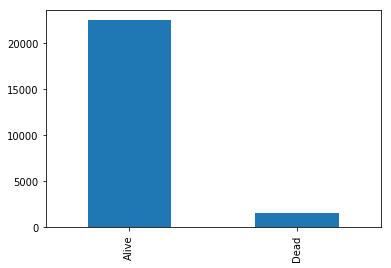

In [15]:
development_data['OutcomeType'].value_counts().plot(kind='bar')

Therefore for this we would use other metrics. There are a lot of metrics to choose from, but the most common are precision, recall and f1-score. From sklearn we can get all of this when printing out the classification report. 

In [16]:
print(metrics.classification_report(validation_outcomes, validation_prediction))

              precision    recall  f1-score   support

       Alive       0.94      1.00      0.97      4501
        Dead       0.00      0.00      0.00       311

   micro avg       0.94      0.94      0.94      4812
   macro avg       0.47      0.50      0.48      4812
weighted avg       0.87      0.94      0.90      4812



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Data cleaning and working with the model was an iterative process for us. As experiment, it was nice that we had an easy model with not too much data so that it could be easily retrained. 

Some experiments we did:

*   using all the different outcome types (Adoption, Died, Euthanasia, Return_to_owner and Transfer)
*  adding more features like color and breed (we spent some time cleaning this up as well)
* Use a random forest classifier
* played with weights for classes
* played with max depth of the tree(s)

We thought the features would have some predictive value, so we added those. While doing that we noticed that the performance of our model got worse. This was not as we expected. When looking into this, we came to the conclusion that we were probable overfitting. To prevent this, we added a maximum depth for the tree(s).

The weights that we gave to the classes, should help to deal with the imbalance of the classes.

We noticed that recall of the category 'Dead' would be the most ideal to optimize on, since we want to make sure that of all the animals who are likely to die, we want as much as them correctly predicted. We don't care if occasionaly we predict that an animal is likely to die, when this will probably not be the case. 
The best model would be one with the highest recall and accuracy (since we don't want to predict that every animal dies). 

One of our best performing models, based on accuracy and recall of the category 'Dead', was a random forest classifier with only the basic features and the binary outcome types. The weight was set 10 for 'Dead' and 1 for 'Alive' and the maximum depth of the trees was 4. We will now train this model. 

In [0]:
from sklearn import ensemble

In [18]:
random_forest = ensemble.RandomForestClassifier(class_weight={'Dead': 10, 'Alive': 1},max_depth=4)
random_forest.fit(hash_features, outcomes)



/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight={'Dead': 10, 'Alive': 1},
            criterion='gini', max_depth=4, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=None, oob_score=False,
            random_state=None, verbose=0, warm_start=False)

Now we are going to check the metrics again for the validation set.

In [19]:
validation_prediction_random_forest = random_forest.predict(validation_features)

print("Validation prediction: \n", validation_prediction_random_forest[:5])

Validation prediction: 
 ['Alive' 'Alive' 'Alive' 'Alive' 'Dead']


In [20]:
print(metrics.accuracy_score(validation_outcomes, validation_prediction_random_forest))

0.728595178719867


The accuracy dropped here if we compare it to our first experiment. However, now our model is able to predict 'Dead' values as well.

In [21]:
print(metrics.classification_report(validation_outcomes, validation_prediction_random_forest))

              precision    recall  f1-score   support

       Alive       0.97      0.74      0.84      4501
        Dead       0.14      0.63      0.23       311

   micro avg       0.73      0.73      0.73      4812
   macro avg       0.55      0.68      0.53      4812
weighted avg       0.91      0.73      0.80      4812



Now would be the time to get the test set of the shelve and let our model make predictions for these. This would be the metrics that we communicate to the customer, since it is the best indication wheter a model would work in real life or not.

In [22]:
test_outcomes = test_data['OutcomeType']
test_features = test_data[feature_columns].applymap(hashFunction)
test_prediction = random_forest.predict(test_features)

print('Test outcomes: \n', test_outcomes.head())
print('\nTest features: \n', test_features.head())
print('\nTest prediction: \n ', test_prediction[:5])

Test outcomes: 
 12380    Alive
5445     Alive
21831    Alive
10081    Alive
12242    Alive
Name: OutcomeType, dtype: object

Test features: 
                 AnimalType       SexuponOutcome  Neutered  Mix
12380  1218296454829451512  4015982136323197781         1    1
5445   1218296454829451512  4015982136323197781         1    0
21831  1218296454829451512 -3317441528169794401         1    1
10081 -6682994201854783480                    0         0    1
12242  1218296454829451512  4015982136323197781         1    1

Test prediction: 
  ['Alive' 'Alive' 'Alive' 'Dead' 'Alive']


In [23]:
print(metrics.accuracy_score(test_outcomes, test_prediction))

0.7246539468761691


In [24]:
print(metrics.classification_report(test_outcomes, test_prediction))

              precision    recall  f1-score   support

       Alive       0.97      0.73      0.83      2493
        Dead       0.15      0.64      0.24       180

   micro avg       0.72      0.72      0.72      2673
   macro avg       0.56      0.69      0.54      2673
weighted avg       0.91      0.72      0.79      2673

